Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch [1/5], Loss: 0.3291, Accuracy: 93.75%
Epoch [2/5], Loss: 0.0334, Accuracy: 100.00%
Epoch [3/5], Loss: 0.0645, Accuracy: 98.44%
Epoch [4/5], Loss: 0.0219, Accuracy: 98.44%
Epoch [5/5], Loss: 0.0402, Accuracy: 98.44%


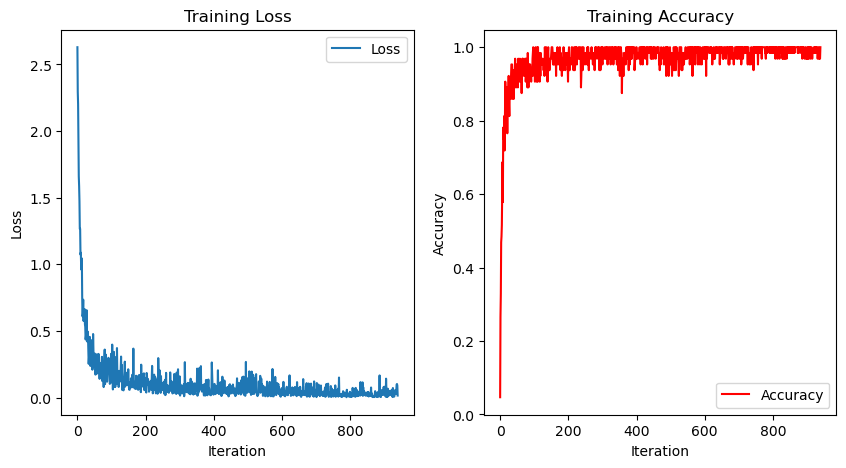

Test Accuracy of the model on the 1000 test images: 98.10 %
Total Number of Parameters in CNN: 29034


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 5
batch_size = 64
learning_rate = 0.001

# Fraction of dataset to use
train_frac = 0.2
test_frac = 0.1

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=False)

# Subset of the dataset
train_subset = torch.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), int(len(train_dataset)*train_frac), replace=False))
test_subset = torch.utils.data.Subset(test_dataset, np.random.choice(len(test_dataset), int(len(test_dataset)*test_frac), replace=False))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=batch_size, shuffle=False)

# Convolutional neural network (CNN)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                   .format(epoch+1, num_epochs, loss.item(), (correct / total) * 100))

# Plot loss and accuracy
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Loss')
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Accuracy', color='r')
plt.title('Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} test images: {:.2f} %'.format(len(test_subset), (correct / total) * 100))

# Print the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Number of Parameters in CNN: {total_params}')
